<a href="https://colab.research.google.com/github/JHyunjun/SNU/blob/main/torch_vision_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Custom Dataset

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code
to be decoupled from our model training code for better readability and modularity.
PyTorch provides two data primitives: ``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``
that allow you to use pre-loaded datasets as well as your own data.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset`` to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that 
subclass ``torch.utils.data.Dataset`` and implement functions specific to the particular data.
They can be used to prototype and benchmark your model. You can find them
here: `Image Datasets <https://pytorch.org/vision/stable/datasets.html>`_,
`Text Datasets  <https://pytorch.org/text/stable/datasets.html>`_, and
`Audio Datasets <https://pytorch.org/audio/stable/datasets.html>`_




In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Other dependencies
import random
import os
import tqdm

import numpy as np
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Iterating and Visualizing the Dataset
-----------------

We can index ``Datasets`` manually like a list: ``training_data[index]``. 
We use ``matplotlib`` to visualize some samples in our training data.



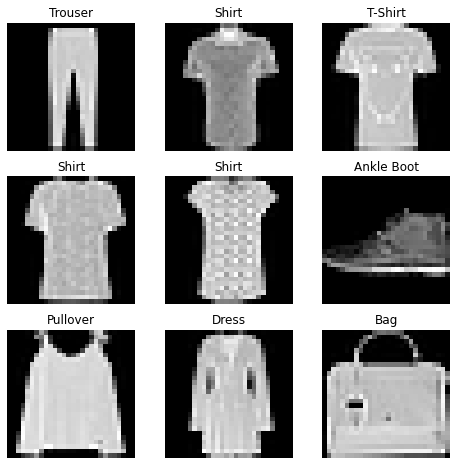

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Preparing your data for training with DataLoaders
-------------------------------------------------
The ``Dataset`` retrieves our dataset's features and labels one sample at a time. While training a model, we typically want to 
pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's ``multiprocessing`` to
speed up data retrieval.

``DataLoader`` is an iterable that abstracts this complexity for us in an easy API.



In [4]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Iterate through the DataLoader
--------------------------

We have loaded that dataset into the ``Dataloader`` and can iterate through the dataset as needed.
Each iteration below returns a batch of ``train_features`` and ``train_labels`` (containing ``batch_size=64`` features and labels respectively).
Because we specified ``shuffle=True``, after we iterate over all batches the data is shuffled (for finer-grained control over 
the data loading order, take a look at `Samplers <https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler>`_).



Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


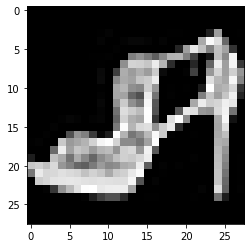

Label: 5


In [5]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.shape}")
print(f"Labels batch shape: {train_labels.shape}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Creating a Custom Dataset for your files
---------------------------------------------------

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`. 
Take a look at this implementation; the FashionMNIST images are stored 
in a directory ``img_dir``, and their labels are stored separately in a CSV file ``annotations_file``. 

In the next sections, we'll break down what's happening in each of these functions.



In [6]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        return sample

`def __init__(self, ...)`


---



The `__init__` function is run once when instantiating the Dataset object. We initialize
the directory containing the images, the annotations file, and both transforms (covered 
in more detail in the next section). 

The labels.csv file looks like: ::

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9



In [7]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

`def __len__(self)`


---



The `__len__` function returns the number of samples in our dataset.

Example:



In [8]:
def __len__(self):
    return len(self.img_labels)

`def __getitem__(self, idx)`
^^^^^^^^^^^^^^^^^^^^

---



The `__getitem__` function loads and returns a sample from the dataset at the given index ``idx``. 
Based on the index, it identifies the image's location on disk, converts that to a tensor using ``read_image``, retrieves the 
corresponding label from the csv data in ``self.img_labels``, calls the transform functions on them (if applicable), and returns the 
tensor image and corresponding label in a Python dict.



In [9]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    sample = {"image": image, "label": label}
    return sample

# Practice

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


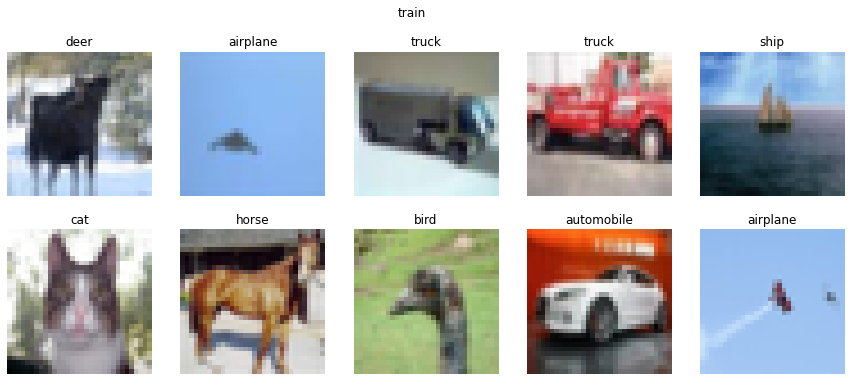

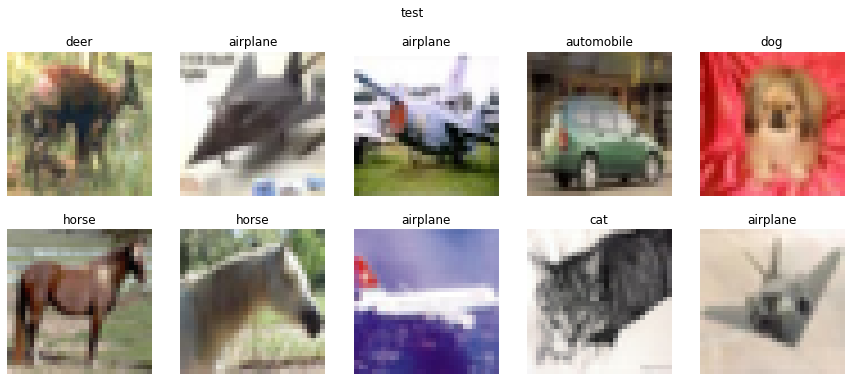

In [10]:
labels_map = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

# TODO 1. load CIFAR10 train dataset from the torchvision
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, transform=transforms.ToTensor(), download=True)
# TODO 2. load CIFAR10 test dataset from the torchvision
test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, transform=transforms.ToTensor(), download=True)
# TODO 3. plot 10 train images and their labels which are returned from the DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
for images, labels in train_dataloader:
  plt.figure(figsize=(15, 6))
  plt.suptitle('train')
  for i in range(len(images)):
    image, label = images[i], labels[i]
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    plt.title(labels_map[label.item()])
    plt.imshow(transforms.ToPILImage()(image))
  break
# TODO 4. plot 10 test images and their labels which are returned from the DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)
for images, labels in test_dataloader:
  plt.figure(figsize=(15, 6))
  plt.suptitle('test')
  for i in range(len(images)):
    image, label = images[i], labels[i]
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    plt.title(labels_map[label.item()])
    plt.imshow(transforms.ToPILImage()(image))
  break

## os



```
os.listdir()
```



In [11]:
os.listdir('data')

['cifar-10-python.tar.gz', 'FashionMNIST', 'cifar-10-batches-py']



```
os.path.join()
```



In [12]:
os.path.join('data', 'FashionMNIST')

'data/FashionMNIST'

## Omniglot Dataset

The Omniglot handwritten character dataset is a dataset for one-shot learning, proposed by Lake et al. It contains 1623 different handwritten characters from 50 different series of alphabets, where each character was handwritten by 20 different people. Each image is 105x105 pixels large. The 50 alphabets are divided into a 30:20 ratio for training and testing, which means that the test set is on a completely new set of characters that are unseen before.
<center><img src="https://i2.wp.com/hugrypiggykim.com/wp-content/uploads/2018/10/omniglot_dataset_characters.jpeg?resize=635%2C289"></center>

https://www.kaggle.com/watesoyan/omniglot

In [13]:
# download omniglot dataset
torchvision.datasets.Omniglot('omniglot', background=True, download=True)
torchvision.datasets.Omniglot('omniglot', background=False, download=True)
;

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting omniglot/omniglot-py/images_background.zip to omniglot/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting omniglot/omniglot-py/images_evaluation.zip to omniglot/omniglot-py


''

In [14]:
# TODO 1. build your own omniglot Dataset
CHAR_TO_LABEL = {}
LABEL_TO_CHAR = {}

class MyOmni(Dataset):
  def __init__(self, root, transform):
    super().__init__()
    self.root = root
    self.transform = transform

    self.image_dirs = list()
    self.labels = list()

    self.nlabel = 0
    for language in os.listdir(root):
      lang_dir = os.path.join(root, language)
      for character in os.listdir(lang_dir):
        char_dir = os.path.join(lang_dir, character)
        unique_char = '_'.join([language, character])

        CHAR_TO_LABEL[unique_char] = self.nlabel
        LABEL_TO_CHAR[self.nlabel] = unique_char

        for fname in os.listdir(char_dir):
          file_path = os.path.join(char_dir, fname)
          self.image_dirs.append(file_path)
          self.labels.append(self.nlabel)
        self.nlabel += 1

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.transform(Image.open(self.image_dirs[idx])), self.labels[idx]

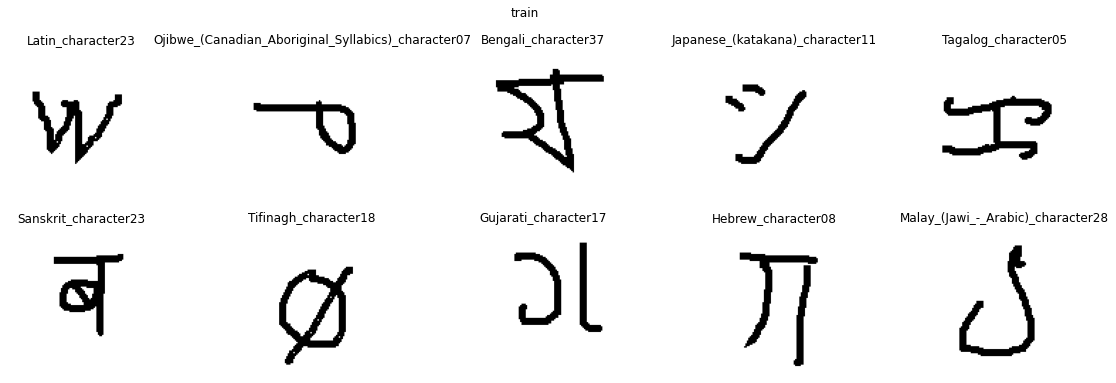

In [15]:
# TODO 1. load you own omniglot train dataset
train_dataset = MyOmni(root=os.path.join('omniglot', 'omniglot-py', 'images_background'), transform=transforms.ToTensor())
# TODO 2. plot 10 train images and their labels which are returned from the DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
for images, labels in train_dataloader:
  plt.figure(figsize=(20, 6))
  plt.suptitle('train')
  for i in range(len(images)):
    image, label = images[i], labels[i]
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    plt.title(LABEL_TO_CHAR[label.item()])
    plt.imshow(image.squeeze(), cmap='gray')
  break

--------------




Further Reading
--------------
- `torch.utils.data API <https://pytorch.org/docs/stable/data.html>`_

